# Model II : XGBoost

This script has completly different structure than RF. It is done stepwise. The conclusion and Test prediciotn are in last two steps.

### Total running time ~30 min (unbiased memory MacOS 16GB)

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, cross_val_predict
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from scipy import stats

In [260]:
data5 = pd.read_csv('data/data_after_prep.csv')

**Hyperparameters:**
<br>

- **n_estimators:** The number of trees in the ensemble, often increased until no further improvements are seen. <br>
- **max_depth:** The maximum depth of each tree, often values are between 1 and 10. <br>
- **eta:** The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller. <br>
- **subsample:** The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples. <br>
- **colsample_bytree:** Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features. <br>

In [261]:
X = data5.drop(columns=['rented_bike_count']) 
y = data5['rented_bike_count']

We will use cross-validation, so we do not need additional validation set (it is included in the training set and assumed in CV function).

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
len(X_train)

X = data5.drop(columns=['rented_bike_count']) 
y = boxcox_target['boxcox_rented_bike_count'] # _t stands for transformed

7458

# Step 1: estimate model with initial parameters

Initial (random) parameters, before gridsearch.

In [263]:
XGBR = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

Let's evaluate the model with initial (random) parameters. We will use the best practice of repeated k-fold cross-validation.

In [264]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores_mae = cross_val_score(XGBR, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(XGBR, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

In [265]:
scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)
print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )

Mean MAE: 90.603 (5.669) Mean MSE: 24022.959


CV error plot

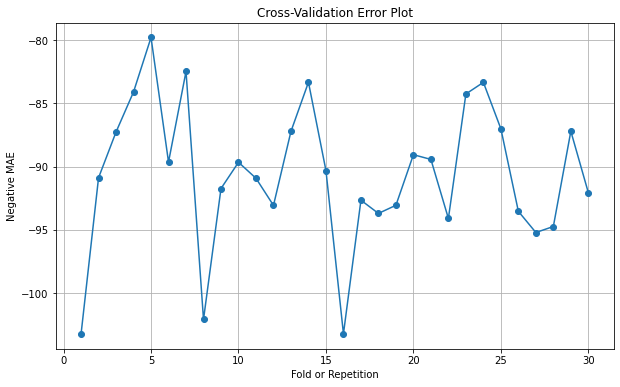

In [266]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores_mae) + 1), -scores_mae, marker='o', linestyle='-')
plt.xlabel('Fold or Repetition')
plt.ylabel('Negative MAE')
plt.title('Cross-Validation Error Plot')
plt.grid(True)
plt.show()

Learning curve

In [267]:
train_sizes, train_scores, val_scores = learning_curve(
    XGBR, X_train, y_train, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)

In [268]:
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

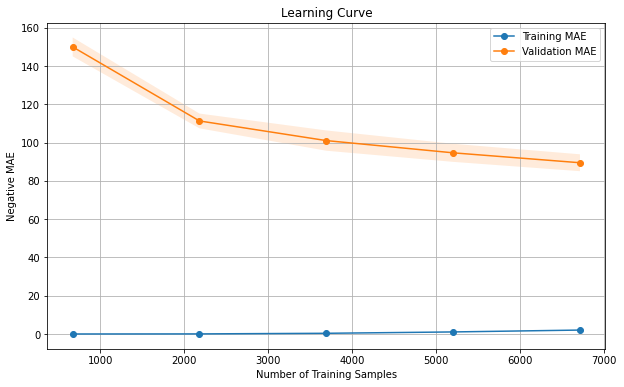

In [269]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training MAE', marker='o', linestyle='-')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, val_mean, label='Validation MAE', marker='o', linestyle='-')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)
plt.xlabel('Number of Training Samples')
plt.ylabel('Negative MAE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 2: GridSearch Cross-Validation on initial parameters

Grid search procedure is hashed, since it is time consuming. The results has been written down after the gridsearch, which helpted to save some time on total running time of the code.

In [270]:
# param_grid = {
#     'n_estimators': [700, 1000, 1200],  # Number of trees
#     'max_depth': [7, 11, 15],  # Maximum depth of trees
#     'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
#     'subsample': [0.6, 0.7, 0.8],  # Fraction of samples used for tree building
#     'colsample_bytree': [0.7, 0.8, 0.9],  # Fraction of features used for tree building
#     # 'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight needed in a child
# }

In [271]:
# grid_search = GridSearchCV(
#     estimator=XGBR,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',  # mean squared error as the evaluation metric 
#     cv=5,  
#     n_jobs=-1,  
#     verbose=2, 
# )

In [272]:
# grid_search.fit(X_train, y_train)

In [273]:
# best_params = grid_search.best_params_
# best_params

In [274]:
best_params = {'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 7,
 'n_estimators': 1200,
 'subsample': 0.7}

In [275]:
# # Assign the estimator to calc the scores below
# best_xgb_model = grid_search.best_estimator_

# To be independent on the gridsearch function, we will define out regressor based on best params, which are defined above
best_xgb_model = xgb.XGBRegressor(**best_params, random_state=123)

# define model evaluation parameters
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [276]:
# evaluate model
scores_mae = cross_val_score(best_xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)
print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )

Mean MAE: 88.257 (5.815) Mean MSE: 22681.700


# Step 3: See how parameters impact the evaluation metric

Improvement.

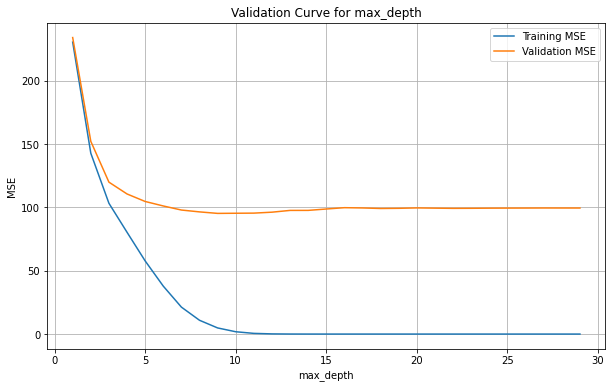

In [277]:
values = list(range(1, 30, 1))
max_depth_values = values
train_scores, validation_scores = validation_curve(
    xgb.XGBRegressor(random_state=123),
    X_train, y_train, param_name='max_depth', param_range=max_depth_values,
    scoring='neg_mean_absolute_error', cv=5)
train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_mse, label='Training MSE')
plt.plot(max_depth_values, validation_mse, label='Validation MSE')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Validation Curve for max_depth')
plt.legend()
plt.grid()
plt.show()


In context of other whole grid: <br>
 'colsample_bytree': 0.9 (max), <br>
 'learning_rate': 0.01 (min), <br>
 'max_depth': 7 (min), <br>
 'n_estimators': 1200 (max), <br>
 'subsample': 0.7 (mid)} <br>
<br>
 max_depth=7 was better than max_depth=11, let's try values from 7 to 11.

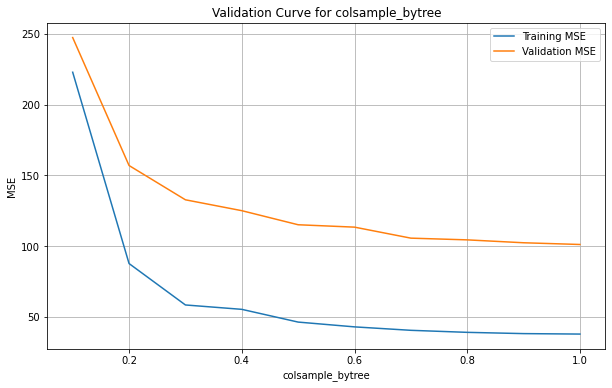

In [278]:
colsample_bytree_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
train_scores, validation_scores = validation_curve(
    xgb.XGBRegressor(random_state=123),
    X_train, y_train, param_name='colsample_bytree', param_range=colsample_bytree_values,
    scoring='neg_mean_absolute_error', cv=5)
train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(colsample_bytree_values, train_mse, label='Training MSE')
plt.plot(colsample_bytree_values, validation_mse, label='Validation MSE')
plt.xlabel('colsample_bytree')
plt.ylabel('MSE')
plt.title('Validation Curve for colsample_bytree')
plt.legend()
plt.grid()
plt.show()


In context of other whole grid: <br>
 'colsample_bytree': 0.9 (max), <br>
 'learning_rate': 0.01 (min), <br>
 'max_depth': 7 (min), <br>
 'n_estimators': 1200 (max), <br>
 'subsample': 0.7 (mid)} <br>
<br>
The higher colsample_bytree, the better MSE score. Let's stay with 0.9 to mitigate the overfitting.

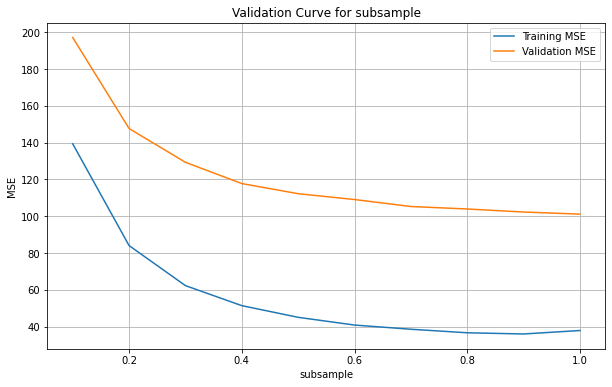

In [279]:
subsample_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
train_scores, validation_scores = validation_curve(
    xgb.XGBRegressor(random_state=123),
    X_train, y_train, param_name='subsample', param_range=subsample_values,
    scoring='neg_mean_absolute_error', cv=5)
train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(subsample_values, train_mse, label='Training MSE')
plt.plot(subsample_values, validation_mse, label='Validation MSE')
plt.xlabel('subsample')
plt.ylabel('MSE')
plt.title('Validation Curve for subsample')
plt.legend()
plt.grid()
plt.show()


In context of other whole grid: <br>
 'colsample_bytree': 0.9 (max), <br>
 'learning_rate': 0.01 (min), <br>
 'max_depth': 7 (min), <br>
 'n_estimators': 1200 (max), <br>
 'subsample': 0.7 (mid)} <br>
<br>
The mid value has been chosen by the grid, let's stay with prevous proposition.

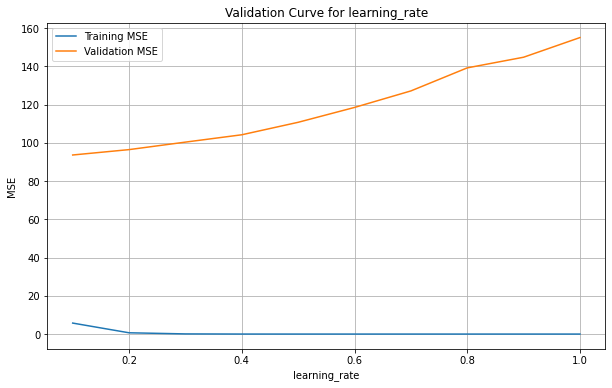

In [280]:
learning_rate_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
train_scores, validation_scores = validation_curve(
    xgb.XGBRegressor(random_state=123, n_estimators = 1200),
    X_train, y_train, param_name='learning_rate', param_range=learning_rate_values,
    scoring='neg_mean_absolute_error', cv=5)
train_mse = -train_scores.mean(axis=1)
validation_mse = -validation_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_values, train_mse, label='Training MSE')
plt.plot(learning_rate_values, validation_mse, label='Validation MSE')
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.title('Validation Curve for learning_rate')
plt.legend()
plt.grid()
plt.show()


In context of other whole grid: <br>
 'colsample_bytree': 0.9 (max), <br>
 'learning_rate': 0.01 (min), <br>
 'max_depth': 7 (min), <br>
 'n_estimators': 1200 (max), <br>
 'subsample': 0.7 (mid)} <br>
<br>

0.2 learning rate is a "break-up" point for training sample's MSE, let's keep current set.

# Step 4: Adjust GridSearch parameters to the context

Again the time saving procedure, results are saved and rewrited.

In [281]:
# param_grid2 = {
#     'n_estimators': [700, 1000, 1200],  # Number of trees
#     'max_depth': [7, 8, 9, 10, 11],  # Maximum depth of trees
#     'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
#     'subsample': [0.6, 0.7, 0.8],  # Fraction of samples used for tree building
#     'colsample_bytree': [0.7, 0.8, 0.9],  # Fraction of features used for tree building
#     # 'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight needed in a child
# }


In [282]:
# grid_search = GridSearchCV(
#     estimator=XGBR,
#     param_grid=param_grid2,
#     scoring='neg_mean_squared_error',  # mean squared error as the evaluation metric 
#     cv=5,  
#     n_jobs=-1,  
#     verbose=2, 
# )

In [283]:
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# best_params

In [284]:
best_params2 = {'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 1200,
 'subsample': 0.8}

In [285]:
# best_xgb_model2 = grid_search.best_estimator_

# To be independent on the gridsearch function, we will define out regressor based on best params, which are defined above
best_xgb_model2 = xgb.XGBRegressor(**best_params2, random_state=123)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [286]:
# evaluate model
scores_mae = cross_val_score(best_xgb_model2, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_xgb_model2, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)
print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )

Mean MAE: 86.323 (5.731) Mean MSE: 22395.190


Improvement.

# Step 5: More adjusting of parameters grid...

In [287]:
# param_grid3 = {
#     'n_estimators': [1000, 1200, 1400],  # Number of trees
#     'max_depth': [7, 8, 9, 10, 11],  # Maximum depth of trees
#     'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
#     'subsample': [0.7, 0.8, 0.85],  # Fraction of samples used for tree building
#     'colsample_bytree': [0.7, 0.8, 0.9],  # Fraction of features used for tree building
#     # 'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight needed in a child
# }

After calculation, we are going to save the results and comment out the commands to improve repoductability of the code. It will impact efficiency of the running time.

In [288]:
# grid_search3 = GridSearchCV(
#     estimator=XGBR,
#     param_grid=param_grid3,
#     scoring='neg_mean_squared_error',  # mean squared error as the evaluation metric 
#     cv=5,  
#     n_jobs=-1,  
#     verbose=2, 
# )

In [289]:
# grid_search3.fit(X_train, y_train)
# best_params1 = grid_search1.best_params_
# best_params1

{'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 1400,
 'subsample': 0.8}

Just checking if different evalutation metric will bring the same results :)

In [290]:
# grid_search3_1 = GridSearchCV(
#     estimator=XGBR,
#     param_grid=param_grid3,
#     scoring='neg_mean_absolute_error',  # mean squared error as the evaluation metric 
#     cv=5,  
#     n_jobs=-1,  
#     verbose=2, 
# )

In [291]:
# grid_search3_1.fit(X_train, y_train)
# best_params2 = grid_search2.best_params_
# best_params2

'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 1400,
 'subsample': 0.8}

It occure that this method has better time efficiency.

Only n_estimators parameter has been adjusted. Let's see if this improved the model. 

In [292]:
best_params3 = {
'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 1400,
 'subsample': 0.8
 }

In [293]:
# Assign the estimator to calc the scores below (it doesn't matter here if we use grid_search3  or grid_search3_1)
# best_xgb_model3 = grid_search3.best_estimator_

# To be independent on the gridsearch function, we will define out regressor based on best params, which are defined above
best_xgb_model3 = xgb.XGBRegressor(**best_params3, random_state=123)

# define model evaluation parameters
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Step 6: Evaluate newest model

In [294]:
# evaluate model
scores_mae = cross_val_score(best_xgb_model3, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_xgb_model3, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)
print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )

Mean MAE: 85.754 (5.740) Mean MSE: 22253.755


Improvemet.

Let's check the MAPE (Mean absolute percentage error).

In [295]:
best_xgb_model3.fit(X_train, y_train)  
y_pred = best_xgb_model3.predict(X_train)  

In [296]:
def custom_mape_scorer(y_true, y_pred):
    ape = abs((y_true - y_pred) / y_true) * 100
    return np.mean(ape)

In [297]:
# Replace scoring method with customized function for MAPE
mape_scores = cross_val_score(best_xgb_model3, X_train, y_train, cv=5, scoring=make_scorer(custom_mape_scorer))

print("MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

MAPE scores: [33.70759534 37.565798   35.74759691 33.40233446 40.36305207]
Mean MAPE: 36.15727535620691


# Step 7: Seek for the field for improvement

BoxCox transformation

In [298]:
transformed_rented_bike_count, lambda_best_fit = stats.boxcox(data5['rented_bike_count'])

boxcox_target = pd.DataFrame()
boxcox_target['boxcox_rented_bike_count'] = transformed_rented_bike_count

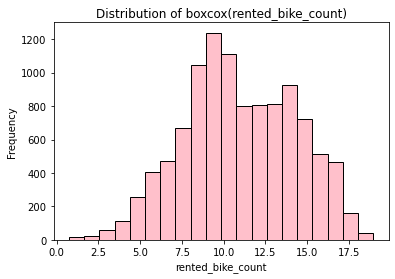

In [299]:
boxcox_target['boxcox_rented_bike_count'].plot(kind='hist', bins=20, edgecolor='black', color='pink')
plt.title('Distribution of boxcox(rented_bike_count)')
plt.xlabel('rented_bike_count')
plt.ylabel('Frequency')
plt.show()
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

In [300]:
X = data5.drop(columns=['rented_bike_count']) 
y = boxcox_target['boxcox_rented_bike_count']

In [301]:
X_train, X_test, y_train_t, y_test_t = train_test_split(X, y, test_size=0.3, random_state=123)
len(X_train)

7458

In [302]:
best_params3 = {
'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 1400,
 'subsample': 0.8
 }

In [303]:
best_xgb_model4 = xgb.XGBRegressor(**best_params3, random_state=123)

In [304]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [305]:
scores_mae = cross_val_score(best_xgb_model4, X_train, y_train_t, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_xgb_model4, X_train, y_train_t, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)
print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )

Mean MAE: 0.528 (0.028) Mean MSE: 0.739


In [306]:
best_xgb_model4.fit(X_train, y_train_t)  
y_pred = best_xgb_model4.predict(X_train)  

In [307]:
mape_scores = cross_val_score(best_xgb_model4, X_train, y_train_t, cv=5, scoring=make_scorer(custom_mape_scorer))

print("MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

MAPE scores: [6.4055897  6.48568964 5.96250311 6.04482245 6.8632239 ]
Mean MAPE: 6.35236575888874


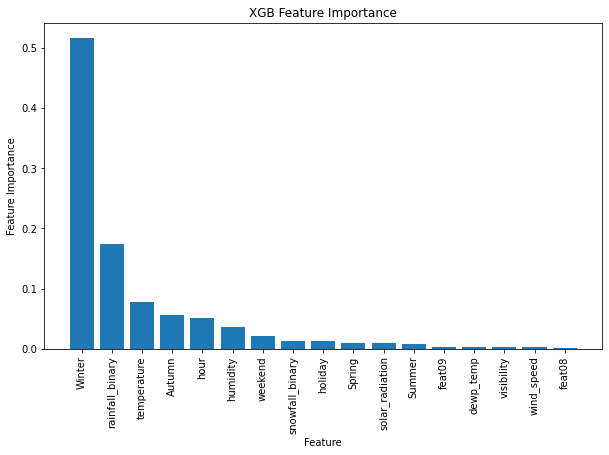

In [308]:
feature_importance = best_xgb_model4.feature_importances_

# Sort feature importance scores and corresponding feature names
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [X.columns[i] for i in sorted_indices]

# Plot the feature importance scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('XGB Feature Importance')
plt.show()

# Step 8: Conclusion

This script doesn't utilize the split to validation sample. **Cross validation tools** has a stength, that they perform a cross-validation on e.g. folds, inside the training sample. This approach helps us to maintain the higher number of observations in the training process, and in conseqence, estimate a better model. 
<br><br>
If it comes to the **xgboost** on its own, its learning curve reveals an interesting pattern, where the training sample MSE increases from some point of training samples. In consequence, we are less willing to increase he training samples to the inifinity, or, dare I say it, too close to the number of observations in the sample (overfitting). 
<br><br>
Next, a consequtive, supervised **GridSearchCV** helped to find the best parameters and estimate the best model. As we do it partially, we save a time dot parsing to much combinations into the function and are able to observe the impact of the single hyperparameters, as well them in the collaboration, on the evaluation metrics.
<br><br>
Finally, the game changer was the **Box-Cox transformation**, which helped to decrease the MAPE 6 times!

# Step 9: Final prediction

In [309]:
y_test_pred = best_xgb_model4.predict(X_test)  

In [310]:
scores_mae = cross_val_score(best_xgb_model4, X_test, y_test_t, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(best_xgb_model4, X_test, y_test_t, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

scores_mae = abs(scores_mae)
scores_mse = abs(scores_mse)

print('Mean MAE: %.3f (%.3f) Mean MSE: %.3f' % (scores_mae.mean(), scores_mae.std(), scores_mse.mean()) )


Mean MAE: 0.632 (0.051) Mean MSE: 1.002


In [311]:
mape_scores = cross_val_score(best_xgb_model4, X_test, y_test_t, cv=5, scoring=make_scorer(custom_mape_scorer))

print("MAPE scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

MAPE scores: [7.2235219  7.86623258 6.1704538  7.91854299 9.11675788]
Mean MAPE: 7.659101831793821


Train sample MAPE ~6 vs test sample MAPE ~7.

# For reverse from box-cox transformed values to the real interpretable values please see the ensembling script.